In [6]:
import networkx as nx
import matplotlib.pyplot as plt

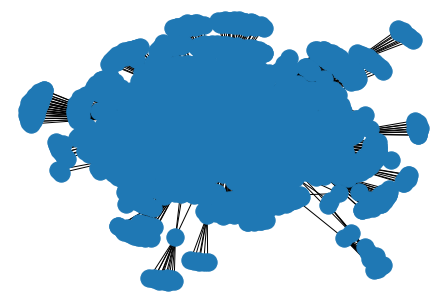

In [7]:
#load the graph
G = nx.read_edgelist("/home/alberto/Documents/GitHub/Learining-From-Networks/Graphs/kw_2.txt")
nx.draw(G)
plt.show()

In [8]:
#compute some centralities
degree_centralities = nx.degree_centrality(G)
closeness_centralities = nx.closeness_centrality(G)
betweenness_centralities = nx.betweenness_centrality(G)

'''
#DA UTILIZZARE CON LE GNN
#create a matrix with shape [num_nodes, num_node_features]
h, w = G.number_of_nodes(), 3
nodes_features = [[0 for x in range(w)] for y in range(h)]
for i in range(G.number_of_nodes()):
    nodes_features[i][0] = list(degree_centralities.values())[i]
    nodes_features[i][1] = list(closeness_centralities.values())[i]
    nodes_features[i][2] = list(betweenness_centralities.values())[i]
'''

In [32]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

spotify = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="f6f2ad1a3118471691471fa533eff1f4", client_secret="40d8cd756cb4474dbab23bcc945528e0"))

In [ ]:
# POPULARITY SCORE
nodes = list(G.nodes)
nodes_popularities = []
for i in range(G.number_of_nodes()):
    nodes_popularities.append(spotify.artist(nodes[i])['popularity'])

print(nodes_popularities)

COMPUTE NODES FEATURES

In [ ]:
#NUMBER OF ALBUMS
nodes_num_albums = []

for i in range(G.number_of_nodes()):
    results = spotify.artist_albums(nodes[i], album_type='album')
    albums = results['items']
    album_ids = []
    while results['next']:
        results = spotify.next(results)
        albums.extend(results['items'])
    for album in albums:
        album_ids.append(album['id'])
    nodes_num_albums.append(len(album_ids))

print(nodes_num_albums)

In [ ]:
#NUMBER OF FOLLOWERS
nodes_followers = []
for i in range(G.number_of_nodes()):
    nodes_followers.append(spotify.artist(nodes[i])['followers']['total'])

print(nodes_followers)

CREATE CSV

In [19]:
import csv

with open("/home/alberto/Documents/GitHub/Learining-From-Networks/test.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL) 
    writer.writerow(['Id','Popularity_score','Closeness_centrality','Betweeness_centrality','Degree_centrality','Num_Albums','Followers'])
    
    for i in range(G.number_of_nodes()):
        r = [nodes[i], nodes_popularities[i], list(closeness_centralities.values())[i], list(betweenness_centralities.values())[i], list(degree_centralities.values())[i], nodes_num_albums[i], nodes_followers[i]]
        writer.writerow(r)   

MACHINE LEARNING

In [20]:
import pandas as pd
import numpy as np
#load the data
df = pd.read_csv('test.csv', sep = ',')

#remove the data samples with missing values (NaN)
df = df.dropna() 

Data = df.values
# m = number of input samples
m = Data.shape[0]
print("Amount of data:",m)
Y = Data[:m,1]
X = Data[:m,2:]

feature_names = df.columns[2:]

Amount of data: 1994


In [21]:
# Split data into train (2/3 of samples), validation (1/6 of samples), and test data (the rest)
m_train = int(2./3.*m)
m_val = int((m-m_train)/2.)
m_test = m - m_train - m_val
print("Amount of data for training and deciding parameters:",m_train)
print("Amount of data for validation (choosing among different models):",m_val)
print("Amount of data for test:",m_test)
from sklearn.model_selection import train_test_split

#Xtrain_and_val, Ytrain_and_val is the part of data for training and validation
#Xtest, Ytest is the part of data for testing
Xtrain_and_val, Xtest, Ytrain_and_val, Ytest = train_test_split(X, Y, test_size=m_test/m)

#if you need to consider a specific training and validation split, use
#Xtrain, Ytrain for training and Xval, Yval for validation
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain_and_val, Ytrain_and_val, test_size=m_val/(m_train+m_val))

Amount of data for training and deciding parameters: 1329
Amount of data for validation (choosing among different models): 332
Amount of data for test: 333


In [25]:
# Data pre-processing
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(Xtrain)
Xtrain_scaled = scaler.transform(Xtrain)
Xtrain_and_val_scaled = scaler.transform(Xtrain_and_val)
Xval_scaled = scaler.transform(Xval)
Xtest_scaled = scaler.transform(Xtest)

In [31]:
# LINEAR REGRESSION 
# not great results

from sklearn import linear_model
#LR the linear regression model
LR = linear_model.LinearRegression()

#fit the model on training data
LR.fit(Xtrain_and_val_scaled, Ytrain_and_val)

print("1 - coefficient of determination on training data:"+str(1 - LR.score(Xtrain_and_val_scaled,Ytrain_and_val)))
print("1 - coefficient of determination on test data:"+str(1 - LR.score(Xtest_scaled,Ytest)))


1 - coefficient of determination on training data:0.5175891358158918
1 - coefficient of determination on test data:0.6055365656696303


In [27]:
# NEURAL NETWORKS

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

mlp_cv = MLPRegressor()
param_grid = {'hidden_layer_sizes': [i for i in range(1,10)],
              'activation': ['relu'],
              'solver': ['lbfgs']
             }
mlp_GS = GridSearchCV(mlp_cv, param_grid=param_grid, 
                   cv=5, verbose=True)
mlp_GS.fit(Xtrain_and_val_scaled, Ytrain_and_val)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/alberto/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/alberto/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/alberto/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status

GridSearchCV(cv=5, estimator=MLPRegressor(),
             param_grid={'activation': ['relu'],
                         'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'solver': ['lbfgs']},
             verbose=True)

In [28]:
#let's print the best model according to grid search
print("Best model: ",mlp_GS.best_estimator_)
#let's print the error 1-R^2 for the best model
print("Error (1-R^2) of best model: ",1. - mlp_GS.best_score_)

Best model:  MLPRegressor(hidden_layer_sizes=6, solver='lbfgs')
Error (1-R^2) of best model:  0.19491046976273962


In [30]:
best_mlp = MLPRegressor(hidden_layer_sizes=(9,), activation='relu', solver='lbfgs')
best_mlp.fit(Xtrain_and_val_scaled,Ytrain_and_val)

print("Error best model on train and validation: ",1. - best_mlp.score(Xtrain_and_val_scaled,Ytrain_and_val))
print("Error best model on test data: ",1. - best_mlp.score(Xtest_scaled,Ytest))

Error best model on train and validation:  0.22720520413498113
Error best model on test data:  0.2492396343011659


/home/alberto/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
